0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np
import matplotlib.pyplot as plt
import copy 

# DDfenics imports
from ddfenics.dd.ddmaterial import DDMaterial 
from ddfenics.dd.ddmetric import DDMetric
from ddfenics.dd.ddfunction import DDFunction
from ddfenics.dd.ddbilinear import DDBilinear
from ddfenics.dd.ddproblem import DDProblem
from ddfenics.dd.ddsolver import DDSolver

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


1) **Consititutive behaviour Definition**

shuffling


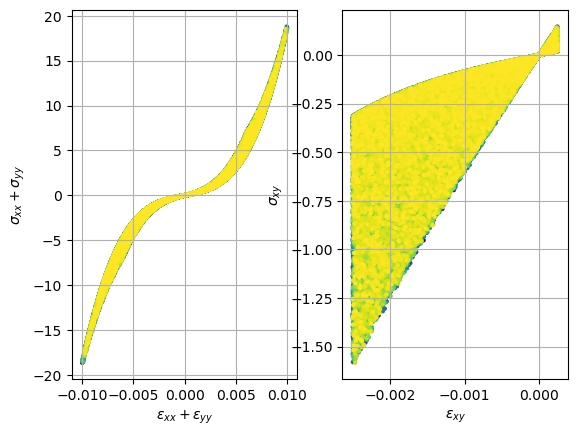

In [2]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
from fetricks import Id_mandel_np, tr_mandel

database_file = 'database_generated.txt' # database_ref.txt to sanity check

Nd = 100000 # number of points

E = 100.0
nu = 0.3
alpha = 10e4
lamb, mu = youngPoisson2lame(nu, E) 

np.random.seed(1)

eps_range = np.array([[-0.008,0.008], [-0.002, 0.002], [-0.0025, 0.00025]]).T
DD = np.zeros((Nd,2,3))

sigma_law = lambda e: (lamb*(1.0 + alpha*tr_mandel(e)**2)*tr_mandel(e)*Id_mandel_np + 
                      2*mu*(1 + alpha*np.dot(e,e))*e)

for i in range(Nd):
    DD[i,0,:] = eps_range[0,:] + np.random.rand(3)*(eps_range[1,:] - eps_range[0,:])
    DD[i,1,:] = sigma_law(DD[i,0,:])
    
np.savetxt(database_file, DD.reshape((-1,6)), header = '1.0 \n%d 2 3 3'%Nd, comments = '', fmt='%.8e', )

ddmat = DDMaterial(database_file)  # replaces sigma_law = lambda u : ...
ddmat.plotDB()

2) **Mesh** (Unchanged) 

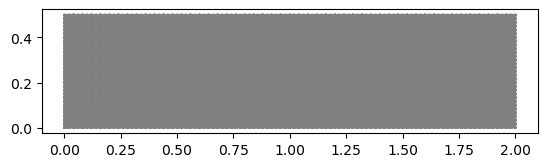

In [3]:
Nx =  100 # x10
Ny =  30 # x10
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** (Unchanged)

In [4]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [5]:
Uh = df.VectorFunctionSpace(mesh, "Lagrange", 1) # Unchanged
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag) # Unchanged

# Space for stresses and strains
Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 

5) **Variational Formulation**: <br>

- Strong format: 
$$
\begin{cases}
div \sigma = 0  \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \\
\varepsilon = \nabla^s u \quad \text{in} \, \Omega \\
\sigma  n  = t \quad \text{on} \, \Gamma_2 \\
\end{cases}
$$ 
- DD equilibrium subproblem: Given $(\varepsilon^*, \sigma^*) \in Z_h$, solve for $(u,\eta) \in U_h$  
$$
\begin{cases}
(\mathbb{C} \nabla^s u , \nabla^s v ) = (\mathbb{C} \varepsilon^* , \nabla^s v ) \quad \forall v \in U_h, \\
(\mathbb{C} \nabla^s \eta , \nabla^s \xi ) = \Pi_{ext}(\xi) - (\sigma^* , \nabla^s \xi ) \quad \forall \xi \in U_h \\
\end{cases}
$$
- Updates:
$$
\begin{cases}
\varepsilon = \nabla^s u \\
\sigma = \sigma^* + \mathbb{C} \nabla^s \eta
\end{cases}
$$
- DD ''bilinear'' form : $(\bullet , \nabla^s v)$ or sometimes  $(\mathbb{C} \nabla^s \bullet, \nabla^s v)$ 

In [6]:
# Unchanged
ty = -0.1
traction = df.Constant((0.0, ty))

u = df.TrialFunction(Uh) 
v = df.TestFunction(Uh)
b = df.inner(traction,v)*ds(loadBndFlag)

a = DDBilinear(ddmat, dx, u, v) # replaces df.inner(sig(u) , df.grad(v))*dx

6) **Statement and Solving the problem** <br> 
- DDProblem : States DD equilibrium subproblem and updates.
- DDSolver : Implements the alternate minimization using SKlearn NearestNeighbors('ball_tree', ...) searchs for the projection onto data.
- Stopping criteria: $\|d_k - d_{k-1}\|/energy$

In [7]:
# Extended solution : replaces u = df.Function(Uh)
sol = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
       "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
       "u" : df.Function(Uh)} # displacemens

# replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
problem = DDProblem(a, b, sol, [bcL], metric = DDMetric(ddmat.C, V = Sh0, dx = dx)) 

start = timer()
#replaces df.LinearVariationalSolver(problem)
solver = DDSolver(problem, opInit = 'random', seed = 1)
tol = 1e-7
hist = solver.solve(tol = tol, maxit = 100);

end = timer()

uh = sol["u"]
normL2 = df.assemble(df.inner(uh,uh)*dx)

print("Time spent: ", end - start)
print("Norm L2: ", normL2)

	Inner Iteration #  1 ,- Relative Error =  9.765364e-01
	Inner Iteration #  2 ,- Relative Error =  1.094847e-01
	Inner Iteration #  3 ,- Relative Error =  1.726113e-01
	Inner Iteration #  4 ,- Relative Error =  1.216591e-01
	Inner Iteration #  5 ,- Relative Error =  7.090094e-02
	Inner Iteration #  6 ,- Relative Error =  4.324726e-02
	Inner Iteration #  7 ,- Relative Error =  2.781249e-02
	Inner Iteration #  8 ,- Relative Error =  1.951026e-02
	Inner Iteration #  9 ,- Relative Error =  1.422512e-02
	Inner Iteration # 10 ,- Relative Error =  1.080809e-02
	Inner Iteration # 11 ,- Relative Error =  8.401248e-03
	Inner Iteration # 12 ,- Relative Error =  6.524394e-03
	Inner Iteration # 13 ,- Relative Error =  5.099360e-03
	Inner Iteration # 14 ,- Relative Error =  4.264851e-03
	Inner Iteration # 15 ,- Relative Error =  3.514978e-03
	Inner Iteration # 16 ,- Relative Error =  2.931014e-03
	Inner Iteration # 17 ,- Relative Error =  2.532614e-03
	Inner Iteration # 18 ,- Relative Error =  1.988

7) **Postprocessing**

a) *Convergence*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


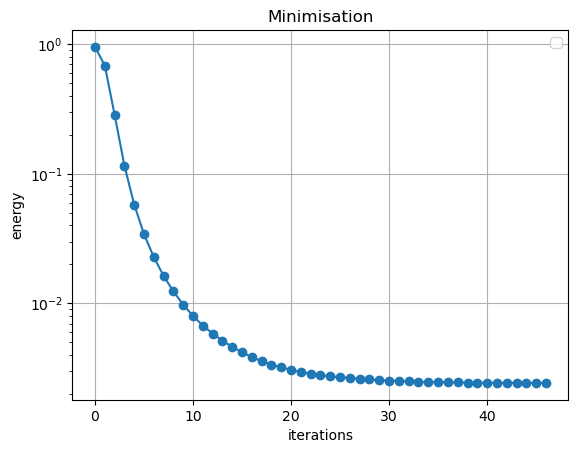

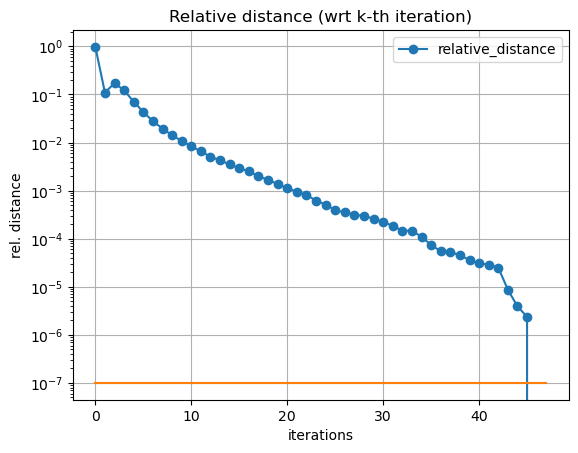

In [8]:
hist = solver.hist

fig = plt.figure(1)
plt.title('Minimisation')
plt.plot(hist['relative_energy'], 'o-')
plt.xlabel('iterations')
plt.ylabel('energy')
plt.legend(loc = 'best')
plt.yscale('log')
plt.grid()

fig = plt.figure(2)
plt.title('Relative distance (wrt k-th iteration)')
plt.plot(hist['relative_distance'], 'o-', label = "relative_distance")
plt.plot([0,len(hist['relative_energy'])],[tol,tol])
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('rel. distance')
plt.legend(loc = 'best')
plt.grid()

c) *Convergence with data*

shuffling
	Inner Iteration #  1 ,- Relative Error =  9.997664e-01
	Inner Iteration #  2 ,- Relative Error =  1.025147e-03
	Inner Iteration #  3 ,- Relative Error =  1.934528e-03
	Inner Iteration #  4 ,- Relative Error =  1.228982e-03
	Inner Iteration #  5 ,- Relative Error =  8.481624e-04
	Inner Iteration #  6 ,- Relative Error =  1.434614e-03
	Inner Iteration #  7 ,- Relative Error =  2.007108e-04
	Inner Iteration #  8 ,- Relative Error =  2.760139e-04
	Inner Iteration #  9 ,- Relative Error =  0.000000e+00
shuffling
	Inner Iteration #  1 ,- Relative Error =  9.985305e-01
	Inner Iteration #  2 ,- Relative Error =  8.522231e-03
	Inner Iteration #  3 ,- Relative Error =  1.388738e-02
	Inner Iteration #  4 ,- Relative Error =  2.111008e-02
	Inner Iteration #  5 ,- Relative Error =  2.208622e-02
	Inner Iteration #  6 ,- Relative Error =  2.114137e-02
	Inner Iteration #  7 ,- Relative Error =  1.886817e-02
	Inner Iteration #  8 ,- Relative Error =  2.123871e-02
	Inner Iteration #  9 ,- Rel

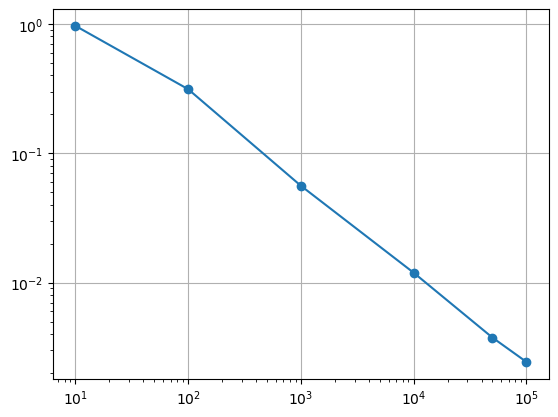

In [9]:
Nd_list = [10,100, 1000, 10000, 50000, 100000] 
hist_list = []
np.random.seed(2)
for Nd_i in Nd_list:
    indexes = np.arange(0,Nd).astype('int')
    np.random.shuffle(indexes)
    DD_i = DD[indexes[:Nd_i], : , : ]
    ddmat_i = DDMaterial(DD_i)
    
    a_i = DDBilinear(ddmat_i, dx, u, v) # replaces df.inner(sig(u) , df.grad(v))*dx

    sol_i = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
           "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
           "u" : df.Function(Uh)} # displacemens
    
    # replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
    problem_i = DDProblem(a_i, b, sol_i, [bcL], metric = DDMetric(ddmat_i.C, V = Sh0, dx = dx)) 
    solver_i = DDSolver(problem_i, opInit = 'zero', seed = 1)
    solver_i.solve(tol = tol, maxit = 100)
    
    hist_list.append(copy.deepcopy(solver_i.hist))
    
    
plt.figure(5)
plt.plot(Nd_list, [hist_list[i]['relative_energy'][-1] for i in range(len(Nd_list))], '-o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

d) *sanity check*

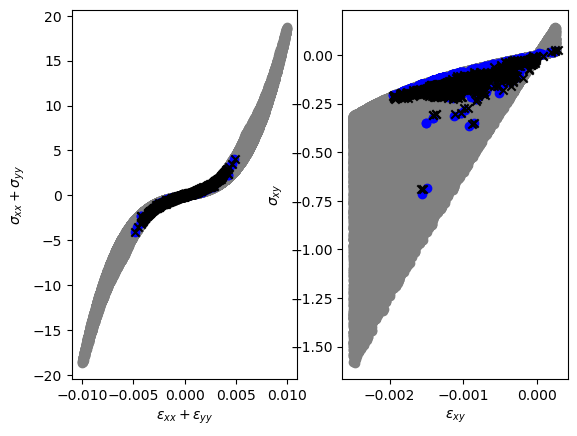

In [41]:
state_mech = sol["state_mech"]
state_db = sol["state_db"]

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.set_xlabel(r'$\epsilon_{xx}+\epsilon_{yy}$')
ax1.set_ylabel(r'$\sigma_{xx}+\sigma_{yy}$')
ax1.scatter(ddmat.DB[:, 0, 0] + ddmat.DB[:, 0, 1], ddmat.DB[:, 1, 0] + ddmat.DB[:, 1, 1], c='gray')
ax1.scatter(state_db[0].data()[:,0]+state_db[0].data()[:,1],state_db[1].data()[:,0]+state_db[1].data()[:,1], c='blue')
ax1.scatter(state_mech[0].data()[:,0]+state_mech[0].data()[:,1],state_mech[1].data()[:,0]+state_mech[1].data()[:,1], marker = 'x', c='black' )

ax2.set_xlabel(r'$\epsilon_{xy}$')
ax2.set_ylabel(r'$\sigma_{xy}$')
ax2.scatter(ddmat.DB[:, 0, 2], ddmat.DB[:, 1, 2], c='gray')
ax2.scatter(state_db[0].data()[:,2], state_db[1].data()[:,2], c='blue')
ax2.scatter(state_mech[0].data()[:,2], state_mech[1].data()[:,2], marker = 'x', c='black')